In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
images_dir = 'data/images/'
csv_file = 'data/data.csv'

In [3]:
data = pd.read_csv(csv_file)
data['image_name'] = data['image_name'].astype(str) + '.jpg'
data['tags'] = data['tags'].apply(lambda x: x.split(' '))

In [4]:
def validConsistentData():
    for index, row in data.iterrows():
        src_path = images_dir
        if not os.path.exists(src_path + row['image_name']):
            print(src_path + image_name)

In [5]:
unique_labels = []
count_labels = 0
for tags in data['tags'].values:
    for tag in tags:
        if tag not in unique_labels:
            unique_labels.append(tag)
            count_labels+=1
unique_labels.sort()

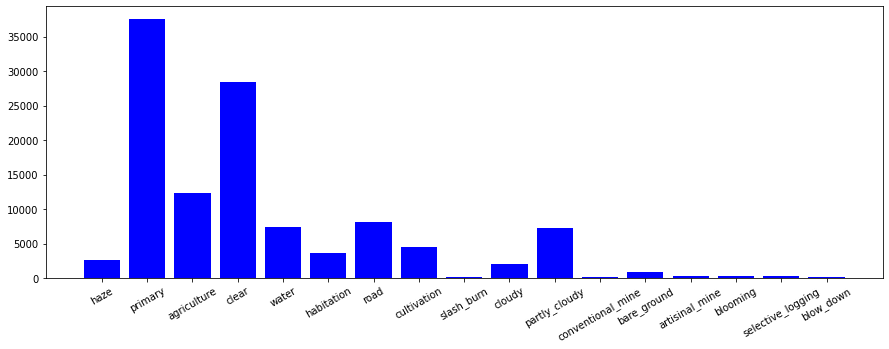

In [6]:
import matplotlib.pyplot as plt

# Dicionário para contagem de imagens por label
labels_count = {}

# Loop
for tag in data['tags'].values:
    for label in tag:
        if label in labels_count:
            labels_count[label] += 1
        else:
            labels_count[label] = 0
            
min_label = min(labels_count, key = labels_count.get)
max_label = max(labels_count, key = labels_count.get)

plt.figure(figsize = (15, 5))

# Plot
plt.bar(range(len(labels_count)), list(labels_count.values()), align = 'center', color = 'blue')
plt.xticks(range(len(labels_count)), list(labels_count.keys()), rotation = 30)
plt.show()

In [7]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [8]:
def oneHotEncode(labels_list):
    onehot = [];
    for label in unique_labels: 
        onehot.append(int(label in labels_list))
    return onehot    

def oneHotDecode(labels_list):
    labels = []
    for i, probability in enumerate(labels_list):
        if probability.item() > 0.7:
            labels.append(unique_labels[i])
    return labels

In [22]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=2, stride=1, padding='same')
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=1, padding='same')
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=1, padding='same')
        self.fc1 = nn.Linear(128 * 8 * 8, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, count_labels)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Model()

criterion = nn.BCEWithLogitsLoss (weight=None, reduce=True)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/home/cristine/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [42]:
import cv2
from PIL import Image
from skimage import io
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, csv_file, images_dir, unique_labels, transform, step):
        self.data = pd.read_csv(csv_file)
        self.images_dir = images_dir
        self.all_image_names = self.data[:]['image_name'] + '.jpg'
        self.labels = self.data[:]['tags']
        self.unique_labels = unique_labels
        self.transform = transform
        self.train_ratio = int(0.8 * len(self.data))
        self.valid_ratio = len(self.data) - self.train_ratio
        self.step = step
        
        if self.step == 'train':
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])
            self.labels = list(self.labels[:self.train_ratio])
            
        elif self.step == 'validation':
            print(f"Number of validation images: {self.valid_ratio}")
            self.image_names = list(self.all_image_names[-self.valid_ratio:-10])
            self.labels = list(self.labels[-self.valid_ratio:])

        elif self.step == 'test':
            self.image_names = list(self.all_image_names[-10:])
            self.labels = list(self.labels[-10:])
        
    def __len__(self):
        return len(self.image_names)
        
    def __getitem__(self, index):
        image = Image.open(os.path.join(self.images_dir + self.image_names[index])).convert("RGB")
        targets = torch.tensor(oneHotEncode(self.labels[index]), dtype=torch.float32)
        data = self.transform(image)
        image = self.images_dir + self.image_names[index]
        return (data, targets, image)

In [24]:
from torch.utils.data import DataLoader

transform = transforms.Compose(
        [
            transforms.Resize((64, 64)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=45),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
#train dataset
data_train = CustomDataset(
    csv_file=csv_file, images_dir=images_dir, unique_labels=unique_labels, 
    transform = transform, step='train'
)
# validation dataset
data_valid = CustomDataset(
   csv_file=csv_file, images_dir=images_dir, unique_labels=unique_labels, 
    transform = transform, step='validation'
)
# test dataset
data_test = CustomDataset(
   csv_file=csv_file, images_dir=images_dir, unique_labels=unique_labels, 
    transform = transform, step='test'
)
# train data loader
train_loader = DataLoader(
    data_train, 
    batch_size=30,
    shuffle=True
)
# validation data loader
valid_loader = DataLoader(
    data_valid, 
    batch_size=30,
    shuffle=False
)
# test data loader
test_loader = DataLoader(
    data_test, 
    batch_size=1,
    shuffle=False
)

Number of training images: 32383
Number of validation images: 8096


In [25]:
def train(train_loader):
    train_loss = 0.0
    batch = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, image = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()
        batch += 1
    return train_loss / batch

In [26]:
def validate(valid_loader):
    valid_loss = 0.0
    batch = 0
    with torch.no_grad():
        for i, data in enumerate(valid_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels, image = data

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # print statistics
            valid_loss += loss.item()
            batch += 1
    return valid_loss / batch

In [27]:
train_error = []
valid_error = []
time = []
for epoch in range(2):  # loop over the dataset multiple times       
    time.append(epoch + 1)       
    train_error.append(train(train_loader))
    valid_error.append(validate(valid_loader))
print('Finished Training')

Finished Training


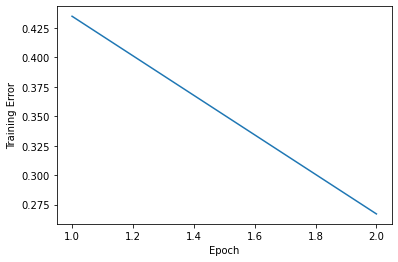

In [28]:
plt.plot(np.array(time), np.array(train_error))
plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.show()

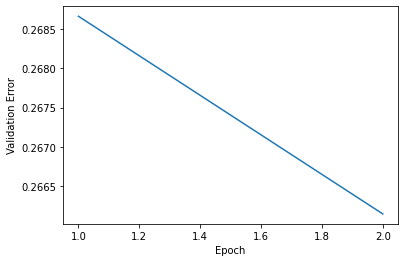

In [29]:
plt.plot(np.array(time), np.array(valid_error))
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
plt.show()

In [30]:
torch.save(model.state_dict(), 'model/tensor.pth')

In [33]:
model = Model()
model.load_state_dict(torch.load('model/tensor.pth'))

<All keys matched successfully>

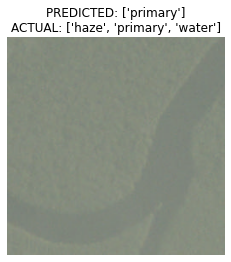

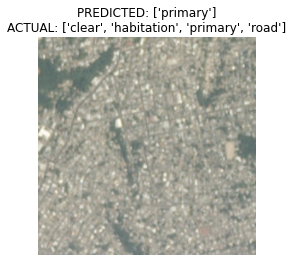

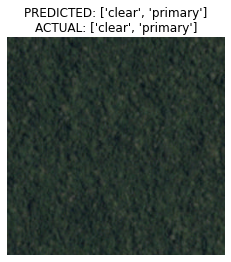

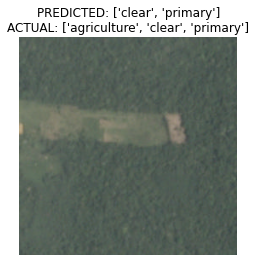

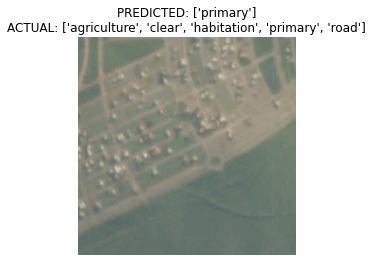

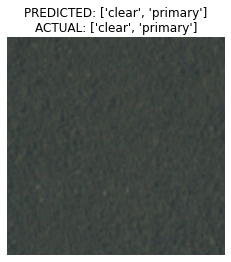

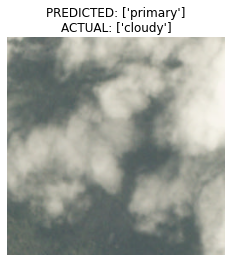

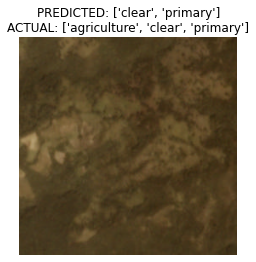

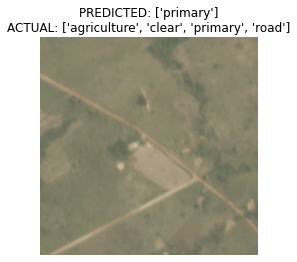

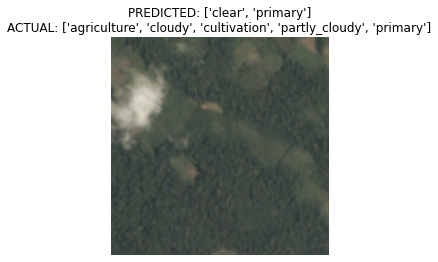

In [50]:
import matplotlib.image as mpimg
%matplotlib inline

for i, data in enumerate(test_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, image = data
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)
        
        string_actual = oneHotDecode(labels[0])
        string_predicted = oneHotDecode(outputs[0])
        
        
        inputs = inputs.squeeze(0)
        inputs = inputs.detach().cpu().numpy()
        inputs = np.transpose(inputs, (1, 2, 0))
    
        img = mpimg.imread(image[0])
        plt.figure()
        plt.title(f"PREDICTED: {string_predicted}\nACTUAL: {string_actual}")
        plt.axis('off')
        plt.imshow(img)

